In [35]:
import pickle
import numpy as np
window_col_bad = pickle.load(open('./data_saved/window_col_bad.p','rb'))
window_col_good = pickle.load(open('./data_saved/window_col_good.p','rb'))
print(len(window_col_bad)+len(window_col_good))
window_col = window_col_good + window_col_bad
labels = np.array([0]*len(window_col_good) + [1]*len(window_col_bad))

814


In [57]:
import numpy as np
from scipy import signal
from scipy.stats import skew,kurtosis
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import RobustScaler
def get_metric(x):
    x = RobustScaler().fit_transform(np.array(x).reshape(-1,1))[:,0]
    f,pxx = signal.welch(x,fs=25,nperseg=len(x)//2)
    pxx = np.abs(pxx)
    pxx = pxx/max(pxx)
    relative_power =  np.trapz(pxx[np.where((f>.8)&(f<2.5))[0]])/np.trapz(pxx[np.where(f>=0)[0]])
    relative_peak_power = np.std(pxx[np.where((f>.8)&(f<2.5))[0]])/np.max(pxx[np.where((f>.8)&(f<2.5))[0]])
    relative_peak_power = relative_peak_power/(relative_peak_power+np.std(pxx)/np.max(pxx))
    peaks_loc1,u = signal.find_peaks(pxx,height=.01)
    a = 0
    b = 0
    for p in peaks_loc1:
        if f[p]>0:
            if .8<f[p]<2.5:
                a+=pxx[p]
            b+=pxx[p]
    if len(peaks_loc1)==0 or a==0:
        relative_peak_power = 0
    else:
        relative_peak_power = a/b
    sk,kr = skew(x),kurtosis(x)
    return [sk,kr,relative_power,relative_peak_power]
feature = np.zeros((0,6))
for i,a in enumerate(window_col):
    if a.shape[0]<50:
        continue
    if 1<(a[-1,0]-a[0,0])/1000<10:
        tmp = get_metric(a[:,4])
        if labels[i]==1:
            if tmp[-1]!=0:
                continue
        duration = (a[-1,0]-a[0,0])/1000
        tmp = tmp + [duration,labels[i]]
        feature = np.concatenate((feature,np.array(tmp).reshape(-1,6)))

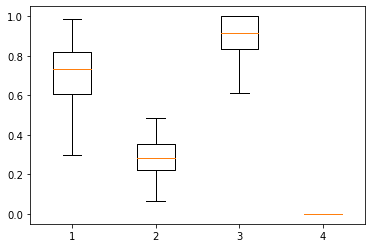

In [60]:
%matplotlib inline
# plt.scatter(feature[:,3],[1]*feature.shape[0],c=feature[:,-1])
# plt.boxplot([feature[feature[:,-1]==0,2],feature[feature[:,-1]==1,2],
#              feature[feature[:,-1]==0,3],feature[feature[:,-1]==1,3]],showfliers=False)
# # plt.colorbar()
# plt.show()

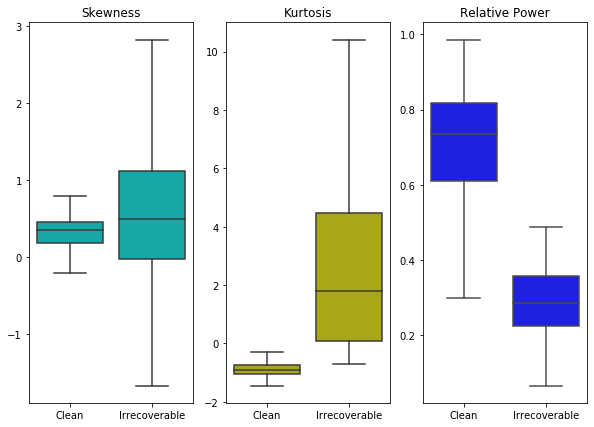

In [83]:
titles = ['Skewness','Kurtosis','Relative Power']
cl = ['c','y','b']
import seaborn as sns
fig,ax = plt.subplots(figsize=(10,7),nrows=1, ncols=3,sharex=False)
for i in range(0,3,1):
    sns.boxplot(y=feature[:,i],
                x=feature[:,-1], ax=ax[i],color=cl[i],showfliers=False)
    plt.setp(ax[i],xticks=[0,1],
         xticklabels=['Clean','Irrecoverable'],title=titles[i])
plt.savefig('./data_saved/signal_quality_distribution.pdf',dps=1000)
plt.show()

In [ ]:
import scipy
scipy.stats.mode(duration_col1)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,4))
sns.scatterplot(x=duration_col1, y=std_col1)
# sns.jointplot(x=duration_col1, y=std_col1,kind='reg')

plt.xlim([0,30])
# plt.colorbar()
plt.savefig('./data_saved/relative_peak_power_dist24.png',dps=10000)
plt.show()